# Imports

In [32]:
import numpy as np
import os
import joblib
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


## set data directory

In [2]:
data_dir = './data/train'

## Images's processing params

In [3]:
img_height, img_width = 150, 150
batch_size = 32

## Using ImageDataGenerator to load and preprocess images

In [4]:
datagen = ImageDataGenerator(rescale=1./255)

# Fonction to load and preprocess images

In [5]:
def load_and_preprocess_images(directory):
    generator = datagen.flow_from_directory(
        directory,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True
    )
    images, labels = [], []
    
    # Obtenir un itérateur sur le générateur
    generator_iter = iter(generator)
    
    # Utiliser next() sur l'itérateur
    for _ in range(len(generator)):
        batch = next(generator_iter)
        images.append(batch[0])
        labels.append(batch[1])
    
    images = np.concatenate(images)
    labels = np.concatenate(labels)
    return images, labels

## load train images

In [6]:
train_images, train_labels = load_and_preprocess_images(data_dir)
print('🟢 data loaded!')


Found 5216 images belonging to 2 classes.
🟢 data loaded!


## Resizing images to transform tehem to feature vectors

In [7]:
train_features = train_images.reshape(train_images.shape[0], -1)

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Use a subset of data for testing

In [9]:
subset_size = 1100
indices = np.random.choice(train_features.shape[0], subset_size, replace=False)

train_features_subset = train_features[indices]
train_labels_subset = train_labels[indices]

## Split data into training and validation/test sets

In [10]:
X_train, X_test, y_train, y_test = train_test_split(train_features_subset, train_labels_subset, test_size=0.2, random_state=42)
print("✅ Data splited!")

✅ Data splited!


## Initialize StandardScaler

In [11]:
scaler = StandardScaler()

## Scaling

In [12]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Set the hyperparameters to test

In [13]:
param_grid = {
    'C': [0.1, 1, 10],
    'solver': ['newton-cg', 'lbfgs']
}


# Initialize the logistic regression model

In [14]:
log_reg = LogisticRegression(max_iter=1000)

## Configure GridSearchCV with cross validation

In [15]:
grid_search = GridSearchCV(log_reg, param_grid, cv=3, scoring='accuracy', n_jobs=-1)

## Run GridSearchCV to find the best hyperparameters

In [16]:
grid_search.fit(X_train_scaled, y_train)

print(f'✅ Best hyperparameters: {grid_search.best_params_}')
print(f'✅ Best cross-validation accuracy: {grid_search.best_score_:.2f}')

✅ Best hyperparameters: {'C': 0.1, 'solver': 'lbfgs'}
✅ Best cross-validation accuracy: 0.95


# Train the model with the best hyperparameters on the full set of scaled train data

In [33]:
best_log_reg = grid_search.best_estimator_
best_log_reg.fit(X_train_scaled, y_train)

# save the model
if not os.path.exists('./models'):
    os.makedirs('./models')

joblib.dump(best_log_reg, './models/logical_regression.pkl')
print("✅ Model saved successfully")


✅ Model saved successfully


## Model performance on classification tasks

In [21]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [22]:
test_predictions = best_log_reg.predict(X_test_scaled)

In [23]:
accuracy_score(y_test, test_predictions)

0.9454545454545454

In [24]:
confusion_matrix(y_test,test_predictions)

array([[ 55,   5],
       [  7, 153]])

## from the model itself

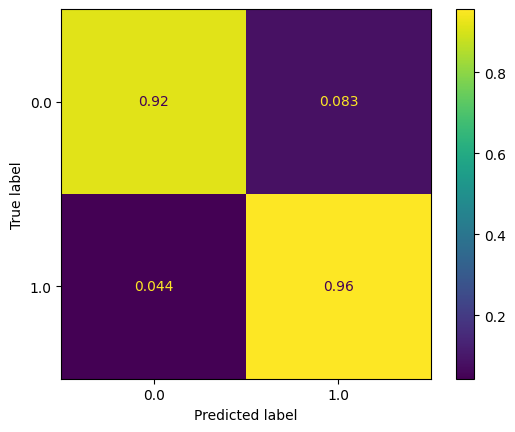

In [25]:
ConfusionMatrixDisplay.from_estimator(best_log_reg,X_test_scaled,y_test,normalize='true');

## from prediction test_predictions

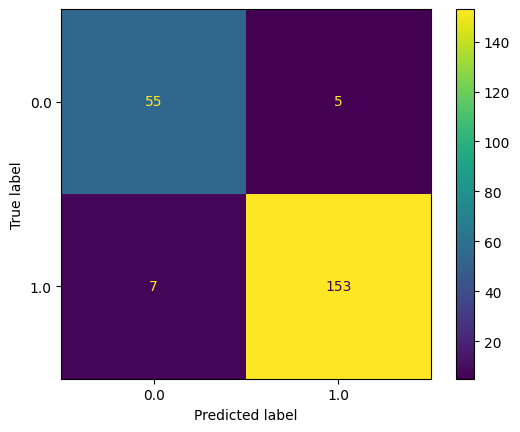

In [26]:
ConfusionMatrixDisplay.from_predictions(y_test, test_predictions);

In [27]:
print(classification_report(y_test,test_predictions))

              precision    recall  f1-score   support

         0.0       0.89      0.92      0.90        60
         1.0       0.97      0.96      0.96       160

    accuracy                           0.95       220
   macro avg       0.93      0.94      0.93       220
weighted avg       0.95      0.95      0.95       220



## Evaluation of curves and AUC

In [28]:
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay

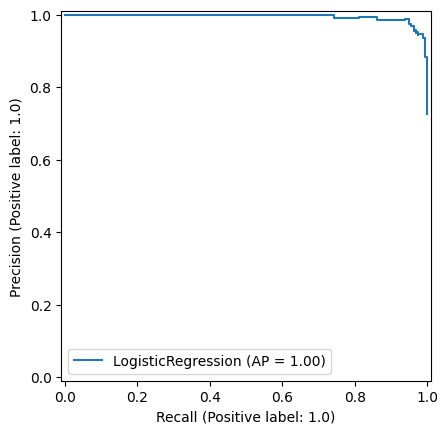

In [29]:
PrecisionRecallDisplay.from_estimator(best_log_reg,X_test_scaled,y_test);

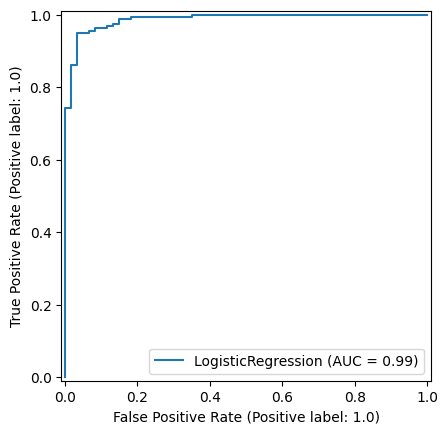

In [30]:
RocCurveDisplay.from_estimator(best_log_reg,X_test_scaled,y_test);